In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

def add_to_path(src_dir):
    if src_dir not in sys.path:
        sys.path.insert(0, src_dir)

add_to_path('code')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import json

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

from easydict import EasyDict as edict

from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn, collate_fn_gqa_objs
from visualize_attentions import plot_word_img_attn_lobs, plot_word_img_attn_objs, idxs_to_question, get_image

In [22]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
model_dir = 'data/gqa_fgt_objs_lobs10/'

with open(os.path.join(model_dir, 'cfg.json'), 'r') as f:
    cfg = json.load(f)

In [6]:
cfg

{'GPU_ID': '0',
 'CUDA': True,
 'WORKERS': 1,
 'LOGDIR': 'gqa_fgt_objs_lobs10',
 'COMET_PROJECT_NAME': 'gqa-objs',
 'EVAL': '',
 'TEST': False,
 'TEST_BATCH_SIZE': 128,
 'SAMPLE': False,
 'resume_model': None,
 'resume_model_ema': None,
 'start_epoch': None,
 'TRAIN': {'FLAG': True,
  'LEARNING_RATE': 0.0001,
  'BATCH_SIZE': 64,
  'MAX_EPOCHS': 40,
  'SNAPSHOT_INTERVAL': 5,
  'WEIGHT_INIT': 'xavier_uniform',
  'CLIP_GRADS': True,
  'CLIP': 8,
  'EALRY_STOPPING': True,
  'PATIENCE': 5,
  'VAR_DROPOUT': False,
  'RADAM': False},
 'DATASET': {'DATASET': 'gqa',
  'DATA_DIR': '/storage1/datasets/GQA/data',
  'COGENT': '',
  'params': {'feats_fname': 'gqa_objects_gt.h5',
   'info_fname': 'gqa_objects_gt_info.json',
   'spatial_feats_dset_name': 'features',
   'objects_feats_dset_name': 'roi_head_features',
   'objects_bboxes_dset_name': 'boxes'}},
 'model': {'init_mem': 'random',
  'max_step': 4,
  'separate_syntax_semantics': False,
  'use_feats': 'objects',
  'num_gt_lobs': 10,
  'common':

In [7]:
from config import __C, _merge_a_into_b

cfg = edict(cfg)
# _merge_a_into_b(cfg, __C)
# cfg = __C

# print(json.dumps(cfg.model, indent=4))

In [12]:
dataset = cfg.DATASET.DATASET

if dataset == 'clevr':
    dataset_root = '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    # dataset_root = '/Users/sebamenabar/Documents/datasets/GQA/'
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir
# cfg.CUDA = False
# cfg.GPU_ID = '-1'

split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
        use_feats=use_feats,
        **cfg.DATASET.params,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(dataset_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']

In [11]:
vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

model = MACNetwork(cfg, vocab, num_answers=num_answers).to(device)
state = torch.load(os.path.join(model_dir, 'Model', 'model_checkpoint_000040.pth'))
print(model.load_state_dict(state['model'], strict=False))
model.eval()

<All keys matched successfully>


MACNetwork(
  (input_unit): InputUnit(
    (stem): Linear(in_features=1028, out_features=512, bias=True)
    (encoder): LSTM(300, 256, batch_first=True, bidirectional=True)
    (encoder_embed): Embedding(2896, 300)
    (embedding_dropout): Dropout(p=0.15, inplace=False)
    (question_dropout): Dropout(p=0.08, inplace=False)
  )
  (output_unit): OutputUnit(
    (question_proj): Linear(in_features=512, out_features=512, bias=True)
    (classifier): Sequential(
      (0): Dropout(p=0.15, inplace=False)
      (1): Linear(in_features=1024, out_features=512, bias=True)
      (2): ELU(alpha=1.0)
      (3): Dropout(p=0.15, inplace=False)
      (4): Linear(in_features=512, out_features=1833, bias=True)
    )
  )
  (mac): MACUnit(
    (control): ControlUnit(
      (attn): Linear(in_features=512, out_features=1, bias=True)
      (control_input): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): Tanh()
      )
      (cont_control): Linear(in_features=1024, 

In [13]:
num_steps = cfg.model.max_step
num_lobs = cfg.model.read_unit.num_lobs
num_gt_lobs = cfg.model.read_unit.num_gt_lobs
read_gate = cfg.model.read_unit.gate
use_feats = cfg.model.use_feats

return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    # 'mac.read.gate_sigmoid': 'read_gate',
    # 'mac.read.lobs_attn_idty': 'lobs_attn',
}
if read_gate:
    return_layers['mac.read.gate_sigmoid'] = 'read_gate'
if num_lobs > 0:
    return_layers['mac.read.lobs_attn_idty'] = 'lobs_attn'  

mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

In [28]:
q_index = 0

if dataset == 'gqa':
    if use_feats == 'spatial':
        gqa_collate_fn = collate_fn_gqa
    elif use_feats == 'objects':
        gqa_collate_fn = collate_fn_gqa_objs
    b = gqa_collate_fn([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])

b['image'] = tuple(v.to(DEVICE) for v in b['image'])
b['question'] = b['question'].to(DEVICE)
# b['question_length'] = b['question_length'].to(DEVICE)

with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'].to(DEVICE), b['question_length'],)

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]
bboxes = b['image'][0][0, :, -4:]
num_gt_objs = b['image'][1].item()

tokenized_questions = idxs_to_question(b['question'][0].detach().cpu().numpy(), vocab['question_idx_to_token'])

In [45]:
def show_and_tell(q_index):
    # q_index = 3

    if dataset == 'gqa':
        if use_feats == 'spatial':
            gqa_collate_fn = collate_fn_gqa
        elif use_feats == 'objects':
            gqa_collate_fn = collate_fn_gqa_objs
        b = gqa_collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    elif dataset == 'clevr':
        b = collate_fn([ds[q_index]])
        image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])

    b['image'] = tuple(v.to(DEVICE) for v in b['image'])
    b['question'] = b['question'].to(DEVICE)
    # b['question_length'] = b['question_length'].to(DEVICE)
        
    with torch.no_grad():
        mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

    pred = vocab['answer_idx_to_token'][output.argmax().item()]
    gt = vocab['answer_idx_to_token'][b['answer'].item()]
    bboxes = b['image'][0][0, :, -4:]
    num_gt_objs = b['image'][1].item()

    tokenized_questions = idxs_to_question(b['question'][0].detach().cpu().numpy(), vocab['question_idx_to_token'])

    fig = plot_word_img_attn_objs(
        mid_outputs,
        num_steps,
        tokenized_questions,
        images_dir,
        image_filename,
        pred,
        gt,
        bboxes=bboxes.detach().cpu().numpy(),
        num_gt_objs=num_gt_objs,
        num_gt_lobs=num_gt_lobs,
    )
    
    cw_ax = fig.get_axes()[1]
    cw_ax.set_title('Question %d' % q_index)
    img_ax = fig.get_axes()[0]
    print(ds.questions[q_index])
    img_ax.set_title(image_filename)
    plt.tight_layout()
    plt.show()
    
    return fig

In [46]:
q_index = 0

{'questionId': '00198497', 'group': 'positionChoose', 'answer': 'left', 'type': 'choose', 'fullAnswer': 'The cups are on the left of the image.', 'question': 'Where are the cups, on the left or on the right of the image?', 'imageId': '2406226'}


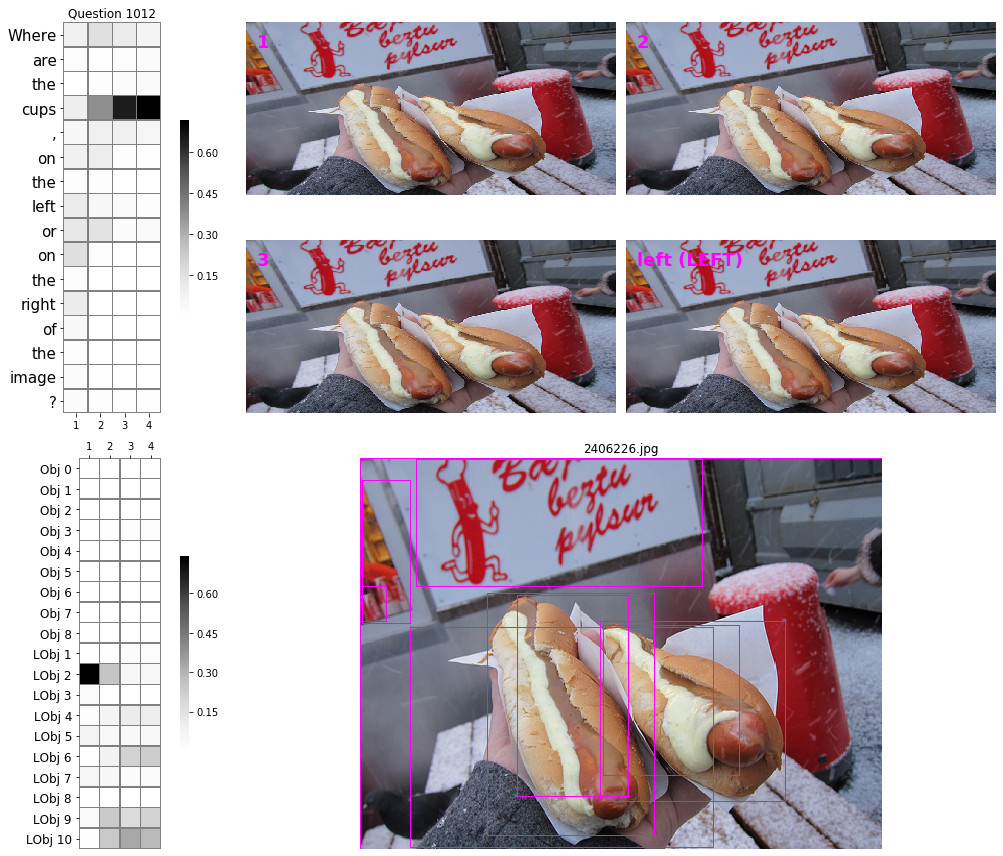

In [139]:
# q_index = 10
fig = show_and_tell(q_index)
q_index += 11

### 

In [90]:
q_index = 4

if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

plot_word_img_attn_lobs(
    mid_outputs,
    num_steps,
    tokenized_questions,
    images_dir,
    image_filename,
    pred,
    gt,
    num_lobs,
    read_gate,
)

# print(mid_outputs['read_gate'])

RuntimeError: size mismatch, m1: [14336 x 7], m2: [2052 x 512] at ../aten/src/TH/generic/THTensorMath.cpp:752